In [142]:
# import everything we may need
import mysql.connector
from mysql.connector import errorcode
import config
import requests
import time
import json
import pandas as pd
%load_ext autoreload
%autoreload 2
import re
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [143]:
# cnx.rollback()
# cursor.close()
# cnx.close()
# connect to AWS
cnx = mysql.connector.connect(
    host = config.host,
    user = config.user,
    passwd = config.password,
    database = 'Mod_1_Project',
    buffered = True
)

# Establish cursor
cursor = cnx.cursor()

In [ ]:
#Create tables to input data
TABLES = {}
TABLES['main_movie_table'] = (
    "CREATE TABLE main_movie_table ("
    "  movie_id int NOT NULL AUTO_INCREMENT,"
    "  title text NOT NULL,"
    "  budget int(10),"
    "  release_date date,"
    "  award_wins int(3),"
    "  award_nominations int(3),"
    "  RT_rating int(2),"
    "  IMDB_rating real,"
    "  PRIMARY KEY (movie_id)"
    ") ENGINE=InnoDB")

TABLES['genres'] = (
    "CREATE TABLE genres ("
    "  genre_id int NOT NULL AUTO_INCREMENT,"
    "  genre text,"
    "  PRIMARY KEY (genre_id)"
    ") ENGINE=InnoDB")

TABLES['key_words'] = (
    "CREATE TABLE key_words ("
    "  keyword_id int NOT NULL AUTO_INCREMENT,"
    "  key_words text,"
    "  PRIMARY KEY (keyword_id)"
    ") ENGINE=InnoDB")

TABLES['movies_genres'] = (
    "CREATE TABLE movies_genres ("
      " movie_id int NOT NULL,"
      " genre_id int NOT NULL"
      ") ENGINE=InnoDB")

TABLES['movies_keywords'] = (
    "CREATE TABLE movies_keywords ("
      " movie_id int NOT NULL,"
      " keyword_id text NOT NULL"
      ") ENGINE=InnoDB")

TABLES['actors'] = (
    "CREATE TABLE actors ("
    " actor_id int NOT NULL AUTO_INCREMENT," 
    " actor_name text NOT NULL,"
    " PRIMARY KEY (actor_id)"
    ") ENGINE=InnoDB")

TABLES['movie_actors'] = (
    "CREATE TABLE movie_actors("
    " movie_id int NOT NULL,"
    " actor_id int NOT NULL"
    ") ENGINE=InnoDB")

create_table(TABLES, 'Mod_1_Project')

In [119]:
import sys
def get_movie_id(title):
    title = title.replace(r"'",r"\'")
    cursor.execute(f"""SELECT movie_id FROM main_movie_table WHERE bom_title = '{title}' OR omdb_title = '{title}';""")
    return cursor.fetchone()

def get_actor_id(actor_name):
    cursor.execute(f"""SELECT actor_id FROM actors WHERE actor_name = '{actor_name}';""")
    return cursor.fetchone()

def pickled_dictionaries_to_df(pickle_names):
    out_list = []
    for filename in pickle_names:
        infile = open(filename,'rb')
        new_dicts = pickle.load(infile)
        infile1.close()
        out_list.extend(new_dicts)
    return pd.DataFrame(out_list)

def add_actors_toDB(omdb_data):
    """Take omdb list of dictionaries and insert actors into """
    idx = 0
    sys.stdout.write("INSERTING ACTORS")
    sys.stdout.flush()
    for movie in omdb_data.itertuples():
        try:
            if movie.Genre != 'Documentary':
                if ',' in movie.Actors:
                    for actor in movie.Actors.split(', '):
                        actor = actor.replace(r"'",r"\'")
                        #get actor_id if already present in database
                        actor_id = get_actor_id(actor)
                        #if actor not present, insert and get id back
                        if actor_id is None:
                            actor_insert_q = f"""INSERT INTO actors(actor_name) VALUES('{actor}');"""
                            cursor.execute(actor_insert_q)
                            cursor.execute("""SELECT LAST_INSERT_ID();""")
                            actor_id = cursor.fetchone()[0]
                        else:
                            actor_id = actor_id[0]

                        #get id of movie
                        movie_id = get_movie_id(movie.Title)[0]

                        insert_actor_movie_q = f"""INSERT INTO movie_actors(movie_id, actor_id) VALUES ('{movie_id}', '{actor_id}');"""
                        #add actor + movie to movie_actors
                        cursor.execute(insert_actor_movie_q)
                        idx += 1
                        if idx % 112 == 0:
                            sys.stdout.write(".")
                            sys.stdout.flush()
                else:
                    print(movie)
            else:
                print(movie)
        except TypeError:
            print('Non-iterable actors movie', movie)
    #add_actors_toDB()  
    cnx.commit()
    sys.stdout.write("OK")
    sys.stdout.flush()

omdb_data = pickled_dictionaries_to_df(['all_data', 'missing_files_found'])
add_actors_toDB(omdb_data)

INSERTING ACTORS...Pandas(Index=97, _1=97, Actors='Al Gore, Cory Booker, George W. Bush, Bill Clinton', Awards='Nominated for 1 BAFTA Film Award. Another 3 wins & 12 nominations.', BoxOffice='$3,456,144', Country='USA', DVD='24 Oct 2017', Director='Bonni Cohen, Jon Shenk', Genre='Documentary', Language='English, French, Russian, German, Mandarin', Metascore=68.0, Plot='A decade after An Inconvenient Truth (2006) brought climate change to the heart of popular culture, the follow-up shows just how close we are to a real energy revolution.', Poster='https://m.media-amazon.com/images/M/MV5BNTkzNTQ0MzA3Ml5BMl5BanBnXkFtZTgwNzg4OTcyMjI@._V1_SX300.jpg', Production='Paramount Pictures', Rated='PG', Ratings="[{'Source': 'Internet Movie Database', 'Value': '6.3/10'}, {'Source': 'Rotten Tomatoes', 'Value': '79%'}, {'Source': 'Metacritic', 'Value': '68/100'}]", Released='04 Aug 2017', Response=True, Runtime='98 min', Title='An Inconvenient Sequel: Truth to Power', Type='movie', Website='https://inc

.Pandas(Index=217, _1=217, Actors='Lee Hwa-Choon, Moon Jae-in, Roh Moo-Hyun, Rhyu Si-Min', Awards=nan, BoxOffice=nan, Country='South Korea', DVD=nan, Director='Chang-jae Lee', Genre='Documentary', Language='English', Metascore=nan, Plot="A look at the life of Roh Moo-hyun, South Korea's president from 2003-2008.", Poster='https://images-na.ssl-images-amazon.com/images/M/MV5BMTc0ODM2OTgyNF5BMl5BanBnXkFtZTgwMzg3ODc2MjI@._V1_SX300.jpg', Production='CJ Entertainment', Rated=nan, Ratings="[{'Source': 'Internet Movie Database', 'Value': '8.4/10'}]", Released='02 Jun 2017', Response=True, Runtime='119 min', Title='Our President', Type='movie', Website=nan, Writer=nan, Year='2017', bom_title='Our President', imdbID='tt7037566', imdbRating=8.4, imdbVotes='34', totalSeasons=nan)
Pandas(Index=221, _1=221, Actors='Agnès Varda, JR, Jeannine Carpentier, Clemens Van Dungern', Awards='Nominated for 1 Oscar. Another 32 wins & 31 nominations.', BoxOffice='$900,903', Country='France', DVD='06 Mar 2018', 

Pandas(Index=304, _1=304, Actors='Elsa Dorfman', Awards=nan, BoxOffice='$121,498', Country='USA', DVD=nan, Director='Errol Morris', Genre='Documentary', Language='English', Metascore=77.0, Plot='A look at the life and work of photographer Elsa Dorfman.', Poster='https://m.media-amazon.com/images/M/MV5BY2EzYjQ3YmQtN2YyYi00YjUyLWI0MTctYTRkNmNjYmRiOTI1XkEyXkFqcGdeQXVyMjU3NTI0Mg@@._V1_SX300.jpg', Production='NEON', Rated='R', Ratings="[{'Source': 'Internet Movie Database', 'Value': '6.6/10'}, {'Source': 'Rotten Tomatoes', 'Value': '96%'}, {'Source': 'Metacritic', 'Value': '77/100'}]", Released='30 Jun 2017', Response=True, Runtime='76 min', Title="The B-Side: Elsa Dorfman's Portrait Photography", Type='movie', Website='http://bsidefilm.com/', Writer=nan, Year='2016', bom_title="The B-Side:Elsa Dorfman's Portrait Photography", imdbID='tt5952468', imdbRating=6.6, imdbVotes='395', totalSeasons=nan)
Pandas(Index=305, _1=305, Actors='Thomas Sung, Hwei Lin Sung, Cyrus Vance Jr., Matt Taibbi', Aw

Pandas(Index=359, _1=359, Actors='Tony Benatatos, Jamal Braithwaite, Steve Buscemi, Joe Casaliggi', Awards='Won 2 Primetime Emmys. Another 6 wins & 6 nominations.', BoxOffice=nan, Country='USA, France', DVD='12 Sep 2002', Director='James Hanlon, Gédéon Naudet, Jules Naudet', Genre='Documentary', Language='English', Metascore=nan, Plot="A real life documentary following the events of September 11 from an insider's view, through the lens of James Hanlon and two French filmmakers who were in Manhattan that one day.", Poster='https://m.media-amazon.com/images/M/MV5BMTIyMzUyNzYzNV5BMl5BanBnXkFtZTcwMTk2NzEyMQ@@._V1_SX300.jpg', Production='Goldfish Pictures', Rated='TV-PG', Ratings="[{'Source': 'Internet Movie Database', 'Value': '8.4/10'}]", Released='10 Mar 2002', Response=True, Runtime='112 min', Title='9/11', Type='movie', Website=nan, Writer='Tom Forman, Greg Kandra', Year='2002', bom_title='9/11', imdbID='tt0312318', imdbRating=8.4, imdbVotes='6,032', totalSeasons=nan)
.Non-iterable act

Pandas(Index=396, _1=396, Actors=nan, Awards=nan, BoxOffice=nan, Country='USA, Australia, Canada, India, UK', DVD=nan, Director='Laurel Chiten', Genre='Documentary', Language='English', Metascore=nan, Plot='A film about the most controversial form of medicine ever invented. Homeopathy', Poster='https://images-na.ssl-images-amazon.com/images/M/MV5BZDdiMzEzNjgtYjQyZS00NDU4LTk3NjgtOWMxYTBjMTA2Njc4XkEyXkFqcGdeQXVyNDk2NzI4OQ@@._V1_SX300.jpg', Production=nan, Rated=nan, Ratings='[]', Released='01 Apr 2017', Response=True, Runtime='66 min', Title='Just One Drop', Type='movie', Website=nan, Writer=nan, Year='2017', bom_title='Just One Drop', imdbID='tt6874242', imdbRating=nan, imdbVotes=nan, totalSeasons=nan)
Pandas(Index=397, _1=397, Actors='Dina Buno, Scott Levin, Frank Costanzo, Jeannie Levin', Awards='6 wins & 3 nominations.', BoxOffice='$90,873', Country='USA', DVD=nan, Director='Antonio Santini, Dan Sickles', Genre='Documentary', Language='English', Metascore=75.0, Plot='An eccentric sub

Non-iterable actors movie Pandas(Index=420, _1=420, Actors=nan, Awards='1 win.', BoxOffice=nan, Country='Canada, USA', DVD=nan, Director='Daniel Cross', Genre='Documentary, History, Music', Language='English', Metascore=nan, Plot='A tour of the juke joints and other venues of the legendary Chitlin Circuit in the Mississippi Delta, including performances by aging blues musicians in their eighties who used to play the circuit.', Poster='https://images-na.ssl-images-amazon.com/images/M/MV5BMjE0MDk1NjIyMF5BMl5BanBnXkFtZTgwMzg1MjEwODE@._V1_SX300.jpg', Production='EyeSteelFilm', Rated=nan, Ratings="[{'Source': 'Internet Movie Database', 'Value': '8.1/10'}, {'Source': 'Rotten Tomatoes', 'Value': '100%'}]", Released='20 Nov 2015', Response=True, Runtime='106 min', Title='I Am the Blues', Type='movie', Website='http://iamthebluesmovie.com/', Writer='Daniel Cross', Year='2015', bom_title='I am the Blues', imdbID='tt5120042', imdbRating=8.1, imdbVotes='44', totalSeasons=nan)
Pandas(Index=426, _1=

.Pandas(Index=481, _1=481, Actors=nan, Awards='2 wins & 2 nominations.', BoxOffice=nan, Country='USA', DVD=nan, Director='Jeremy S. Levine, Landon Van Soest', Genre='Documentary', Language='English', Metascore=nan, Plot="After a school fight lands 17-year old Daje Shelton in a court-supervised alternative high school, she's determined to turn things around and make a better future for herself in her rough ...", Poster='https://images-na.ssl-images-amazon.com/images/M/MV5BZTk5NzY3ZTUtZjBlMy00NTBmLWIzMTgtM2E4OTNiZDY1MDBlXkEyXkFqcGdeQXVyNDY2NDMxNDY@._V1_SX300.jpg', Production='Transient Pictures', Rated=nan, Ratings="[{'Source': 'Internet Movie Database', 'Value': '8.1/10'}, {'Source': 'Rotten Tomatoes', 'Value': '96%'}]", Released='23 Apr 2017', Response=True, Runtime='90 min', Title='For Ahkeem', Type='movie', Website='http://forahkeemfilm.com', Writer=nan, Year='2017', bom_title='For Ahkeem', imdbID='tt5119268', imdbRating=8.1, imdbVotes='19', totalSeasons=nan)
Pandas(Index=484, _1=484

Non-iterable actors movie Pandas(Index=515, _1=515, Actors=nan, Awards='5 wins & 1 nomination.', BoxOffice='$4,024', Country='USA', DVD=nan, Director='Lara Stolman', Genre='Documentary, Drama, Family, Sport', Language='English', Metascore=72.0, Plot='SWIM TEAM chronicles the overwhelming struggles and extraordinary triumphs of 3 young athletes with autism and shows how a swim team can bring hope to a community.', Poster='https://m.media-amazon.com/images/M/MV5BMjI5Nzg2NDIzNV5BMl5BanBnXkFtZTgwMDg1NjEwMDI@._V1_SX300.jpg', Production='Woodland Park Productions', Rated=nan, Ratings="[{'Source': 'Internet Movie Database', 'Value': '7.9/10'}, {'Source': 'Rotten Tomatoes', 'Value': '100%'}, {'Source': 'Metacritic', 'Value': '72/100'}]", Released='07 Jul 2017', Response=True, Runtime='90 min', Title='Swim Team', Type='movie', Website='http://www.swimteamthefilm.com/', Writer=nan, Year='2016', bom_title='Swim Team', imdbID='tt4382330', imdbRating=7.9, imdbVotes='85', totalSeasons=nan)
Pandas(In

Pandas(Index=545, _1=545, Actors=nan, Awards='8 wins & 7 nominations.', BoxOffice=nan, Country='India, Germany, Finland', DVD=nan, Director='Rahul Jain', Genre='Documentary', Language='Hindi, English', Metascore=76.0, Plot='Director Rahul Jain presents an intimate, observantly portrayal of the rhythm of life and work in a gigantic textile factory in Gujarat, India. Moving through the corridors and bowels of ...', Poster='https://m.media-amazon.com/images/M/MV5BMjI3NjE1NzgwNl5BMl5BanBnXkFtZTgwNjY2NzE5MDI@._V1_SX300.jpg', Production='Jann Pictures', Rated=nan, Ratings="[{'Source': 'Internet Movie Database', 'Value': '7.3/10'}, {'Source': 'Rotten Tomatoes', 'Value': '92%'}, {'Source': 'Metacritic', 'Value': '76/100'}]", Released='24 Feb 2017', Response=True, Runtime='71 min', Title='Machines', Type='movie', Website='http://machines-themovie.com/', Writer=nan, Year='2016', bom_title='Machines', imdbID='tt5690244', imdbRating=7.3, imdbVotes='428', totalSeasons=nan)
.Non-iterable actors movi

Pandas(Index=592, _1=592, Actors="Richard 'Rick' Misener, Brian Nazarof, Eldra 'Vegas' III Jackson, Neseli 'Kiki' Tagoai", Awards='4 wins & 10 nominations.', BoxOffice=nan, Country='USA', DVD=nan, Director='Jairus McLeary, Gethin Aldous(co-director)', Genre='Documentary', Language='English', Metascore=84.0, Plot='Set inside a single room in Folsom Prison, three men from the outside participate in a four-day group-therapy retreat with a group of incarcerated men for a real look at the challenges of rehabilitation.', Poster='https://m.media-amazon.com/images/M/MV5BMjI2ZmQxZGEtMzQyNi00NGYyLTk4ODctN2M3Y2FkZTU2MTEyXkEyXkFqcGdeQXVyNzk1Mzg3NTY@._V1_SX300.jpg', Production='Blanketfort Media', Rated='Not Rated', Ratings="[{'Source': 'Internet Movie Database', 'Value': '7.9/10'}, {'Source': 'Rotten Tomatoes', 'Value': '100%'}, {'Source': 'Metacritic', 'Value': '84/100'}]", Released='08 Sep 2017', Response=True, Runtime='89 min', Title='The Work', Type='movie', Website='https://theworkmovie.com/'

.Pandas(Index=625, _1=625, Actors=nan, Awards=nan, BoxOffice='$744', Country='USA', DVD=nan, Director='Alan Govenar', Genre='Documentary', Language='English', Metascore=nan, Plot=nan, Poster=nan, Production='First Run Features', Rated=nan, Ratings='[]', Released='15 Sep 2017', Response=True, Runtime='84 min', Title='Extraordinary Ordinary People', Type='movie', Website='http://firstrunfeatures.com/extraordinaryordinarypeople.html', Writer='Alan Govenar, Jason Johnson-Spinos', Year='2017', bom_title='Extraordinary Ordinary People', imdbID='tt7379362', imdbRating=nan, imdbVotes=nan, totalSeasons=nan)
Pandas(Index=630, _1=630, Actors='Simon Fitzmaurice, Ruth Fitzmaurice, Damien Fitzmaurice, Florence Fitzmaurice', Awards='2 wins & 8 nominations.', BoxOffice=nan, Country='Ireland', DVD=nan, Director='Frankie Fenton', Genre='Documentary', Language='English', Metascore=75.0, Plot="It's Not Yet Dark tells the ground breaking story of Simon Fitzmaurice, a talented young Irish film maker with AL

Pandas(Index=810, _1=810, Actors='Kristen Bell, Wen Lei Bi, Rong Hou, Ben Kilham', Awards=nan, BoxOffice=nan, Country='USA', DVD=nan, Director='David Douglas, Drew Fellman', Genre='Documentary', Language='English', Metascore=82.0, Plot='In the mountains of Sichuan, China, a researcher forms a bond with Qian Qian, a panda who is about to experience nature for the first time.', Poster='https://m.media-amazon.com/images/M/MV5BMTg3NzY4NTI3N15BMl5BanBnXkFtZTgwMzc0MDc4NDM@._V1_SX300.jpg', Production='IMAX', Rated='G', Ratings="[{'Source': 'Internet Movie Database', 'Value': '7.4/10'}, {'Source': 'Rotten Tomatoes', 'Value': '100%'}, {'Source': 'Metacritic', 'Value': '82/100'}]", Released='06 Apr 2018', Response=True, Runtime='42 min', Title='Pandas', Type='movie', Website='https://www.imax.com/movies/pandas', Writer='Drew Fellman', Year='2018', bom_title='Pandas', imdbID='tt7860270', imdbRating=7.4, imdbVotes='312', totalSeasons=nan)
.Pandas(Index=839, _1=839, Actors='Angelika Baumbach, Gaura

Pandas(Index=874, _1=874, Actors='Peter Beard, Lee Radziwill, Jacqueline Kennedy, Caroline Kennedy', Awards=nan, BoxOffice=nan, Country='Sweden, Denmark, USA', DVD=nan, Director='Göran Olsson', Genre='Documentary', Language='English', Metascore=62.0, Plot='Montauk, East Hampton, New York, 2016. Peter Beard discusses his work as a photographer, artist and diarist before reminiscing about his attempt to make a documentary in the summer of 1972 ...', Poster='https://m.media-amazon.com/images/M/MV5BNDZhMjU2NjgtNDRkOS00YjllLTg1NTItYmEwYTg1MTFlYTQyXkEyXkFqcGdeQXVyNDY2NDMxNDY@._V1_SX300.jpg', Production=nan, Rated='Unrated', Ratings="[{'Source': 'Internet Movie Database', 'Value': '6.1/10'}, {'Source': 'Metacritic', 'Value': '62/100'}]", Released='18 May 2018', Response=True, Runtime='80 min', Title='That Summer', Type='movie', Website=nan, Writer=nan, Year='2017', bom_title='That Summer', imdbID='tt7057306', imdbRating=6.1, imdbVotes='160', totalSeasons=nan)
Pandas(Index=881, _1=881, Actors=

Pandas(Index=931, _1=931, Actors=nan, Awards=nan, BoxOffice=nan, Country='USA', DVD=nan, Director='Erik Nelson', Genre='Documentary', Language='English', Metascore=nan, Plot="A tribute to one of the world's great filmmakers and the men of the 8th Air Force who flew mission after suicidal mission in the Second World War.", Poster='https://m.media-amazon.com/images/M/MV5BNGQ1M2QwYjMtZjEyZS00Y2UxLWJlNzMtN2U2NmIzNDgxYzc5XkEyXkFqcGdeQXVyNjg3MDMxNzU@._V1_SX300.jpg', Production='Fathom Events', Rated='Not Rated', Ratings="[{'Source': 'Internet Movie Database', 'Value': '8.1/10'}, {'Source': 'Rotten Tomatoes', 'Value': '100%'}]", Released='17 Jun 2018', Response=True, Runtime='72 min', Title='The Cold Blue', Type='movie', Website=nan, Writer=nan, Year='2018', bom_title='The Cold Blue', imdbID='tt8693770', imdbRating=8.1, imdbVotes='109', totalSeasons=nan)
Pandas(Index=933, _1=933, Actors='Torsten Blume, Rosan Bosch, Alfredo Brillembourg, Hubert Klumpner', Awards=nan, BoxOffice=nan, Country='Ge

Pandas(Index=966, _1=966, Actors='Gcina Mhlophe', Awards='3 wins.', BoxOffice=nan, Country='Swaziland, Qatar, USA', DVD=nan, Director='Aaron Kopp, Amanda Kopp', Genre='Documentary, Animation', Language='English', Metascore=80.0, Plot='Five children in Swaziland dive into their imaginations to create an original African tale about a girl on a dangerous quest.', Poster='https://m.media-amazon.com/images/M/MV5BYmQ3NDQ5MjEtNzM2MC00Y2NhLThkN2ItMzlmNWVjYzJlNmU2XkEyXkFqcGdeQXVyNzg1NTk1MjA@._V1_SX300.jpg', Production='Abramorama', Rated=nan, Ratings="[{'Source': 'Internet Movie Database', 'Value': '7.1/10'}, {'Source': 'Rotten Tomatoes', 'Value': '100%'}, {'Source': 'Metacritic', 'Value': '80/100'}]", Released='10 Oct 2018', Response=True, Runtime='77 min', Title='Liyana', Type='movie', Website='http://www.liyanathemovie.com/', Writer=nan, Year='2017', bom_title='Liyana', imdbID='tt6977442', imdbRating=7.1, imdbVotes='166', totalSeasons=nan)
Non-iterable actors movie Pandas(Index=969, _1=969, 

Pandas(Index=1016, _1=1016, Actors=nan, Awards=nan, BoxOffice=nan, Country='Singapore, USA, Argentina, Canada, India, Italy, UK', DVD=nan, Director='Satinder Garcha, Mike Rogers(co-director), Meghan Shea(co-director)', Genre='Documentary', Language='English', Metascore=nan, Plot="A young, modern, Sikh family travels the globe meeting with diverse communities of Sikhs to explore their roots and identity in Sikhism, the world's fifth largest religion.", Poster='https://m.media-amazon.com/images/M/MV5BMWZiN2U1OTktZmNlZi00ZDA4LThkNWYtYTA0YzU1YWE2Zjk5XkEyXkFqcGdeQXVyMjU4MDUyNA@@._V1_SX300.jpg', Production=nan, Rated=nan, Ratings="[{'Source': 'Internet Movie Database', 'Value': '5.7/10'}]", Released='23 Oct 2016', Response=True, Runtime='89 min', Title='Under the Turban', Type='movie', Website=nan, Writer=nan, Year='2016', bom_title='Under the Turban', imdbID='tt5700402', imdbRating=5.7, imdbVotes='6', totalSeasons=nan)
Pandas(Index=1020, _1=1020, Actors="Geoff Dyer, Jeffrey Fraenkel, Susan 

Non-iterable actors movie Pandas(Index=1048, _1=1048, Actors=nan, Awards=nan, BoxOffice=nan, Country=nan, DVD=nan, Director=nan, Genre=nan, Language=nan, Metascore=nan, Plot=nan, Poster='https://m.media-amazon.com/images/M/MV5BNzUyZTdhMGEtMGU4OC00MzYxLWE4MjMtY2FiYjI1Y2I0N2MwXkEyXkFqcGdeQXVyNTg4NjU4NzE@._V1_SX300.jpg', Production='Trafalgar Releasing', Rated=nan, Ratings='[]', Released='08 Feb 2019', Response=True, Runtime=nan, Title='Josh Groban Bridges from Madison Square Garden', Type='movie', Website=nan, Writer=nan, Year='2019', bom_title='Josh Groban Bridges from Madison Square Garden', imdbID='tt9902734', imdbRating=nan, imdbVotes=nan, totalSeasons=nan)
.Pandas(Index=1055, _1=1055, Actors='Alex Gibbs, Hawthorne James, Leon, Robert Townsend', Awards=nan, BoxOffice=nan, Country='USA', DVD=nan, Director='Robert Townsend', Genre='Documentary', Language='English', Metascore=nan, Plot='The behind the scene look at the casting calls; selection of cast members, story board ideas producer

Pandas(Index=1123, _1=1123, Actors='Jeremy Quinn, Ramaz Nikoladze, Giorgi Natenadze, Mariam Iosebidze', Awards=nan, BoxOffice=nan, Country='USA', DVD='20 Mar 2018', Director='Emily Railsback', Genre='Documentary', Language='English, Georgian', Metascore=nan, Plot='Filmmaker Emily Railsback and award-winning sommelier Jeremy Quinn provide intimate access to rural family life in the Republic of Georgia as they explore the rebirth of 8,000-year-old ...', Poster='https://ia.media-imdb.com/images/M/MV5BMWUxODgwZmMtODJlYy00YWU5LWJmNWQtZDI5NDUyNzhiODllXkEyXkFqcGdeQXVyNDU0NjMyNTQ@._V1_SX300.jpg', Production='Music Box Films', Rated='NOT RATED', Ratings="[{'Source': 'Internet Movie Database', 'Value': '5.9/10'}, {'Source': 'Rotten Tomatoes', 'Value': '80%'}]", Released='09 Mar 2018', Response=True, Runtime='78 min', Title='Our Blood Is Wine', Type='movie', Website='https://www.georgianwinedoc.com/', Writer=nan, Year='2018', bom_title='Our Blood is Wine', imdbID='tt7660966', imdbRating=5.9, imdb

Pandas(Index=1209, _1=1209, Actors='B-Real, Steven Hager, Damian Marley, Snoop Dogg', Awards=nan, BoxOffice=nan, Country=nan, DVD='20 Apr 2019', Director='Fab 5 Freddy', Genre='Documentary', Language=nan, Metascore=nan, Plot="A look at America's complicated relationship with cannabis.", Poster='https://m.media-amazon.com/images/M/MV5BZjE4ZmY0OGUtNDAwYy00MTcwLWJiMjEtM2YzN2ZlNThhYjc2XkEyXkFqcGdeQXVyNzg5MzIyOA@@._V1_SX300.jpg', Production=nan, Rated=nan, Ratings="[{'Source': 'Internet Movie Database', 'Value': '7.1/10'}, {'Source': 'Rotten Tomatoes', 'Value': '100%'}]", Released='20 Apr 2019', Response=True, Runtime='97 min', Title='Grass is Greener', Type='movie', Website=nan, Writer=nan, Year='2019', bom_title='Grass ', imdbID='tt10050782', imdbRating=7.1, imdbVotes='628', totalSeasons=nan)
.Pandas(Index=1226, _1=1226, Actors='André Leon Talley, Manolo Blahnik, Naomi Campbell, Betty Catroux', Awards=nan, BoxOffice=nan, Country='USA', DVD=nan, Director='Kate Novack', Genre='Documentary',

Pandas(Index=1298, _1=1298, Actors='John Adams, Steve Bullock', Awards='1 nomination.', BoxOffice=nan, Country='USA', DVD=nan, Director='Kimberly Reed', Genre='Documentary', Language='English', Metascore=72.0, Plot='DARK MONEY, a political thriller, examines one of the greatest present threats to American democracy: the influence of untraceable corporate money on our elections and elected officials. ...', Poster='https://m.media-amazon.com/images/M/MV5BMzRlNThmZTctZjA5NC00NWJjLTk2MTItNTI2ODg3MmVjYzk1XkEyXkFqcGdeQXVyODk4NjgxOTU@._V1_SX300.jpg', Production='PBS', Rated='TV-14', Ratings="[{'Source': 'Internet Movie Database', 'Value': '7.1/10'}, {'Source': 'Rotten Tomatoes', 'Value': '95%'}, {'Source': 'Metacritic', 'Value': '72/100'}]", Released='13 Jul 2018', Response=True, Runtime='99 min', Title='Dark Money', Type='movie', Website='https://www.darkmoneyfilm.com/', Writer='Kimberly Reed, Jay Arthur Sterrenberg', Year='2018', bom_title='Dark Money', imdbID='tt6633182', imdbRating=7.1, i

.Pandas(Index=1348, _1=1348, Actors='Woody Allen, Wes Anderson, Anthony Bourdain, Rob Bowman', Awards=nan, BoxOffice=nan, Country='USA', DVD=nan, Director='Matthew Miele', Genre='Documentary', Language='English', Metascore=49.0, Plot='The iconic Carlyle hotel has been an international destination for a particular jet-set as well as a favorite haunt of the most discernible New Yorkers.', Poster='https://m.media-amazon.com/images/M/MV5BMmU0YjI5ODMtYzRmMC00NzRlLWE3NzEtMzE3MzkwYzVjNmU3XkEyXkFqcGdeQXVyMTI4Mjg4MjA@._V1_SX300.jpg', Production='Good Deed Entertainment', Rated='PG-13', Ratings="[{'Source': 'Internet Movie Database', 'Value': '6.2/10'}, {'Source': 'Rotten Tomatoes', 'Value': '58%'}, {'Source': 'Metacritic', 'Value': '49/100'}]", Released='11 May 2018', Response=True, Runtime='92 min', Title='Always at The Carlyle', Type='movie', Website='http://www.alwaysatthecarlyle.com', Writer='Matthew Miele', Year='2018', bom_title='Always at the Carlyle', imdbID='tt4151320', imdbRating=6.2,

Pandas(Index=1404, _1=1404, Actors='Ben Anderson, Ashley Cooper, Brad Cooper, Danielle Cooper', Awards=nan, BoxOffice=nan, Country='USA', DVD=nan, Director='Martin Butler', Genre='Documentary', Language='English', Metascore=nan, Plot="A humble sportscaster/plane crash survivor joins forces with ultra-competitive CEO in the world's most grueling bicycle endurance race. Driven by their shared convictions, they cycle 3,000+...", Poster='https://images-na.ssl-images-amazon.com/images/M/MV5BOTQxZGM3OWQtODUyNi00ZTJlLWJiMWQtMjJlMzg4ZWZiZDlhXkEyXkFqcGdeQXVyMTU5NDYyNjA@._V1_SX300.jpg', Production=nan, Rated=nan, Ratings='[]', Released='06 Jun 2017', Response=True, Runtime='113 min', Title='Godspeed: The Race Across America', Type='movie', Website=nan, Writer=nan, Year='2016', bom_title='GODSPEED The Race Across America', imdbID='tt6082798', imdbRating=nan, imdbVotes=nan, totalSeasons=nan)
.Pandas(Index=1417, _1=1417, Actors=nan, Awards=nan, BoxOffice=nan, Country='USA', DVD=nan, Director='Rory 

Pandas(Index=1452, _1=1452, Actors='Jex Blackmore, Chalice Blythe, Nicholas Crowe, Sal De Ciccio', Awards=nan, BoxOffice=nan, Country='USA', DVD=nan, Director='Penny Lane', Genre='Documentary', Language='English', Metascore=76.0, Plot='A look at the quick rise and influence of the controversial religious group known as The Satanic Temple.', Poster='https://m.media-amazon.com/images/M/MV5BMjRlNGY2MTUtYzNmZi00ZDRjLWFjNWQtOWJjZDZjMDhmMDAyXkEyXkFqcGdeQXVyMzQyMzAxNjg@._V1_SX300.jpg', Production='Magnolia Pictures', Rated='R', Ratings="[{'Source': 'Internet Movie Database', 'Value': '6.8/10'}, {'Source': 'Rotten Tomatoes', 'Value': '97%'}, {'Source': 'Metacritic', 'Value': '76/100'}]", Released='17 Apr 2019', Response=True, Runtime='95 min', Title='Hail Satan?', Type='movie', Website='https://www.hailsatanfilm.com/', Writer=nan, Year='2019', bom_title='Hail Satan?', imdbID='tt9358044', imdbRating=6.8, imdbVotes='663', totalSeasons=nan)
Pandas(Index=1454, _1=1454, Actors='John Lydon, Martin A

Pandas(Index=1496, _1=1496, Actors='Dante Barksdale, Monique Brown, Clayton Gunton, Tia Latrell', Awards=nan, BoxOffice=nan, Country='USA', DVD=nan, Director='Marilyn Ness', Genre='Documentary', Language='English', Metascore=85.0, Plot='During three years of unparalleled violence in Baltimore, CHARM CITY delivers an unexpectedly candid, observational portrait of those left on the frontlines. With grit, fury, and compassion...', Poster='https://m.media-amazon.com/images/M/MV5BNGViYjBiYTAtMTA3Mi00ZGMxLWI0NjEtZGRjNTE3OWEwMWE3XkEyXkFqcGdeQXVyMzAyMzE2MzM@._V1_SX300.jpg', Production=nan, Rated='TV-MA', Ratings="[{'Source': 'Internet Movie Database', 'Value': '7.4/10'}, {'Source': 'Rotten Tomatoes', 'Value': '100%'}, {'Source': 'Metacritic', 'Value': '85/100'}]", Released='22 Apr 2018', Response=True, Runtime='108 min', Title='Charm City', Type='movie', Website=nan, Writer=nan, Year='2018', bom_title='Charm City', imdbID='tt8196200', imdbRating=7.4, imdbVotes='98', totalSeasons=nan)
Non-itera

Pandas(Index=1574, _1=1574, Actors='Travis Wilkerson', Awards='1 nomination.', BoxOffice=nan, Country='USA', DVD=nan, Director='Travis Wilkerson', Genre='Documentary', Language='English', Metascore=78.0, Plot="A documentary murder mystery about the filmmaker's family, set in lower Alabama.", Poster='https://m.media-amazon.com/images/M/MV5BNTY0Njc1NjQzMl5BMl5BanBnXkFtZTgwMjg4OTQ3NDM@._V1_SX300.jpg', Production='Grasshopper Film', Rated=nan, Ratings="[{'Source': 'Internet Movie Database', 'Value': '6.7/10'}, {'Source': 'Rotten Tomatoes', 'Value': '84%'}, {'Source': 'Metacritic', 'Value': '78/100'}]", Released='20 Jan 2017', Response=True, Runtime='90 min', Title='Did You Wonder Who Fired the Gun?', Type='movie', Website='http://grasshopperfilm.com/film/did-you-wonder-who-fired-the-gun/', Writer='Travis Wilkerson (story)', Year='2017', bom_title='Did You Wonder Who Fired the Gun?', imdbID='tt6370614', imdbRating=6.7, imdbVotes='190', totalSeasons=nan)
Pandas(Index=1579, _1=1579, Actors='N

.Pandas(Index=1628, _1=1628, Actors='Georgia Angelopoulos, Jacques Berchtold, J. Keith Elliott, Craig A. Evans', Awards=nan, BoxOffice=nan, Country='USA', DVD=nan, Director='Reuben Evans', Genre='Documentary', Language='English', Metascore=nan, Plot='Dr. Craig Evans travels the globe to track down the most ancient New Testament manuscripts. Along the way, he highlights groundbreaking new evidence, demonstrating the reliability of the New Testament manuscripts.', Poster='https://m.media-amazon.com/images/M/MV5BNTZmODg2MjgtNjRlYi00N2YyLWFhMTYtZDE1YTU0MDg5MWNmXkEyXkFqcGdeQXVyODAxNzk2NjM@._V1_SX300.jpg', Production='Fathom Events', Rated=nan, Ratings="[{'Source': 'Internet Movie Database', 'Value': '8.9/10'}]", Released='24 Apr 2018', Response=True, Runtime='75 min', Title='Fragments of Truth', Type='movie', Website=nan, Writer='Reuben Evans', Year='2018', bom_title='Fragments of Truth', imdbID='tt7499368', imdbRating=8.9, imdbVotes='16', totalSeasons=nan)
Pandas(Index=1632, _1=1632, Actor

Pandas(Index=1675, _1=1675, Actors=nan, Awards=nan, BoxOffice=nan, Country='USA', DVD=nan, Director='Jeremy Frindel', Genre='Documentary', Language='English, Marathi', Metascore=nan, Plot="The story of Dr. Vasant Lad's mission to bring the ancient health care system of wellness called Ayurveda from India to the West in the late 1970s. From the director of One Track Heart: The Story of Krishna Das.", Poster='https://ia.media-imdb.com/images/M/MV5BMGI2ODA2NDUtN2IxNi00NjEwLWFkOTItNDA0ZmIyZTA0MDVkXkEyXkFqcGdeQXVyMjI3NDAyNg@@._V1_SX300.jpg', Production='Zeitgeist Films', Rated='UNRATED', Ratings="[{'Source': 'Internet Movie Database', 'Value': '6.8/10'}, {'Source': 'Rotten Tomatoes', 'Value': '40%'}]", Released='02 Feb 2018', Response=True, Runtime='89 min', Title='The Doctor from India', Type='movie', Website=nan, Writer=nan, Year='2018', bom_title='The Doctor from India', imdbID='tt7999770', imdbRating=6.8, imdbVotes='11', totalSeasons=nan)
Pandas(Index=1682, _1=1682, Actors='Willem Dafoe

In [140]:
from bs4 import BeautifulSoup
from imdb import IMDb
import inspect

def get_awards(movie_title, ia):
    try:
        movie = ia.search_movie(movie_title)[0]
    except IndexError:
        return None
    url_stem = 'https://www.imdb.com/title/tt'
    soup = BeautifulSoup(requests.get(url_stem+movie.getID()+'/awards').text)
    try:
        awards_text = soup.select('#main .desc')[0].string
    except IndexError:
        return None
    awards_words = awards_text.split()
    try:
        return {awards_words[3]:int(awards_words[2]), awards_words[6]:int(awards_words[5])}
    except IndexError:
        return None


In [152]:
from urllib.parse import urlencode
from imdb import IMDb
import sys

cnx = mysql.connector.connect(
                host = config.host,
                user = config.user,
                passwd = config.password,
                database = 'Mod_1_Project',
                buffered = True
            )

cursor = cnx.cursor()
def update_movies_with_awards():
    idx = 0
    sys.stdout.write('[')
    sys.stdout.flush()
    ia = IMDb()
    cursor.execute("""SELECT bom_title FROM main_movie_table WHERE award_nominations IS NULL;""")
    titles = [title[0] for title in cursor.fetchall()]
    try:
        for title in titles:

            try:
                win = list(get_awards(title,ia).keys())[0]
                nom = list(get_awards(title,ia).keys())[1]
                award_wins = get_awards(title,ia)[win]
                award_noms = get_awards(title,ia)[nom]
            except Exception as e:
                award_wins = 'NULL'
                award_noms = 'NULL'
            title = title.replace(r"'", r"\'")
            award_update_q = f"""UPDATE main_movie_table 
                                SET award_wins = {award_wins}, award_nominations = {award_noms}
                                WHERE bom_title = '{title}';"""
            cursor.execute(award_update_q)
            idx += 1
            if idx % 23 == 0:
                cnx.commit()
                cursor.close()
                cnx.close()
                cnx = mysql.connector.connect(
                    host = config.host,
                    user = config.user,
                    passwd = config.password,
                    database = 'Mod_1_Project',
                    buffered = True
                )

                cursor = cnx.cursor()
                sys.stdout.write('=')
                sys.stdout.flush()
    finally:
        cnx.commit()
        sys.stdout.write(']')
        sys.stdout.flush()

[=============]

KeyboardInterrupt: 

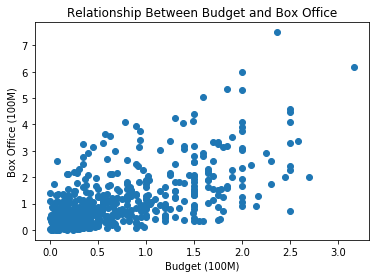

In [128]:
%matplotlib inline
import matplotlib.pyplot as plt
cursor.execute('''SELECT bom_title, budget, box_office FROM main_movie_table mmt WHERE budget > 0 AND box_office > 0;''')
result_set = cursor.fetchall()
titles = []
budgets = []
box_offices = []
for title, budget, box_office in result_set:
    titles.append(title)
    budgets.append(budget)
    box_offices.append(box_office)
fig, ax = plt.subplots()
ax.scatter(budgets, box_offices)
ax.set_xlabel('Budget (100M)')
ax.set_ylabel('Box Office (100M)')
ax.set_title('Relationship Between Budget and Box Office')
# for idx, title in enumerate(titles):
#     plt.annotate(title, (budgets[idx], box_offices[idx]))
ax.yaxis.offsetText.set_visible(False)
ax.xaxis.offsetText.set_visible(False)

fig.savefig('scatter_plot', dpi=500)


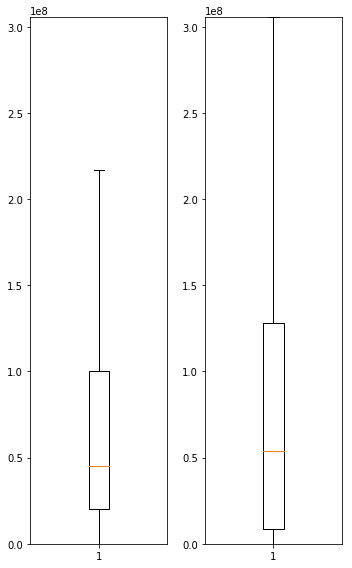

In [28]:
fig, axs = plt.subplots(nrows=1, ncols=2, squeeze=False, figsize=(5,8))
budget_result = axs.flat[0].boxplot(budgets, 0, '')
box_office_result = axs.flat[1].boxplot(box_offices, 0, '')
# budget_extremes = np.concatenate([line.get_ydata() for line in budget_result['whiskers']])
box_office_extremes = np.concatenate([line.get_ydata() for line in box_office_result['whiskers']])
ymax = max(box_office_extremes)
ymin = min(box_office_extremes)
axs.flat[0].set_ylim([ymin,ymax])
axs.flat[1].set_ylim([ymin,ymax])
plt.tight_layout()
plt.show()

<IPython.core.display.Javascript object>


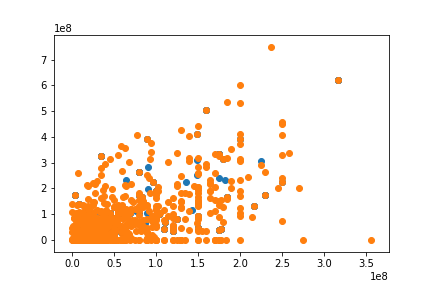

In [115]:
import mpld3
%matplotlib notebook  
import matplotlib.pyplot as plt

cursor.execute("""SELECT a.actor_name, AVG(budget), AVG(box_office)
                    FROM main_movie_table mmt
                    JOIN movie_actors ma ON mmt.movie_id = ma.movie_id
                    JOIN actors a ON ma.actor_id = a.actor_id
                    WHERE budget < (SELECT AVG(budget) FROM main_movie_table)
                    AND box_office > (SELECT AVG(box_office) FROM main_movie_table)
                    GROUP BY ma.actor_id""")
result_set = cursor.fetchall()
names = []
budget_avgs = []
movie_gross_avgs = []
for name, budget, box_office in result_set:
    names.append(name)
    budget_avgs.append(budget)
    movie_gross_avgs.append(box_office)
fig, ax = plt.subplots()
scatter = ax.scatter(budget_avgs, movie_gross_avgs)

# for idx, name in enumerate(names):
#     plt.annotate(name, (budget_avgs[idx], movie_gross_avgs[idx]))
plt.show()

<IPython.core.display.Javascript object>


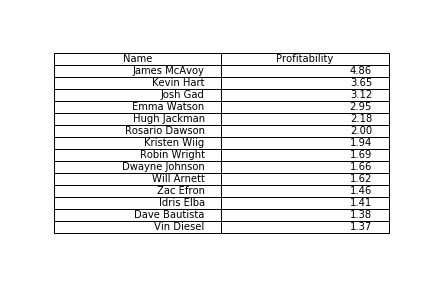

In [113]:
# We took the avg budgets and 
cursor.execute("""SELECT subquery.actor_name, ROUND(avg_bo/avg_budget, 2) as profitability
                    FROM (SELECT a.actor_name, AVG(mmt.budget) as avg_budget, AVG(mmt.box_office) as avg_bo, COUNT(DISTINCT mmt.movie_id) as movies
                    FROM main_movie_table mmt
                    JOIN movie_actors ma ON mmt.movie_id = ma.movie_id
                    JOIN actors a ON ma.actor_id = a.actor_id
                    WHERE mmt.release_date > '2016-12-31'
                    AND budget > 0
                    AND box_office > 0
                    GROUP BY a.actor_name) subquery
                    WHERE movies > 1
                    HAVING profitability > 1.3
                    ORDER BY profitability DESC;""")
actors = cursor.fetchall()
columns = ('Name', 'Profitability')
fig, ax = plt.subplots()
ax.axis('tight')
ax.axis('off')
ax.table(cellText=actors, colLabels=columns, loc='center')
fig.savefig('actor_summary_table', dpi=500)


In [87]:
cursor.execute("""SELECT COUNT(movie_id) FROM main_movie_table WHERE YEAR(release_date) = 2017;""")
cursor.fetchall()

[(581,)]

In [92]:
cursor.execute("""SELECT a.actor_name, budget, box_office
               FROM main_movie_table mmt
                    JOIN movie_actors ma ON mmt.movie_id = ma.movie_id
                    JOIN actors a ON ma.actor_id = a.actor_id
                    WHERE mmt.release_date > '2016-12-31'
                    AND budget IS NOT NULL
                    AND box_office IS NOT NULL
                    AND a.actor_name IN ('Jessica Rothe',
                                            'James McAvoy',
                                            'Kevin Hart',
                                            'Josh Gad',
                                            'Jon Hamm',
                                            'Amandla Stenberg',
                                            'Dakota Johnson',
                                            'Cate Blanchett',
                                            'Idris Elba',
                                            'Dwayne Johnson')
                    ORDER BY a.actor_name;""")
cursor.fetchall()

[('Amandla Stenberg', 10000000, 34091886),
 ('Amandla Stenberg', 10000000, 34091886),
 ('Amandla Stenberg', 10000000, 34091886),
 ('Amandla Stenberg', 10000000, 34091886),
 ('Amandla Stenberg', 10000000, 34091886),
 ('Amandla Stenberg', 23000000, 0),
 ('Amandla Stenberg', 34000000, 0),
 ('Cate Blanchett', 180000000, 314971245),
 ('Cate Blanchett', 180000000, 314971245),
 ('Cate Blanchett', 180000000, 314971245),
 ('Cate Blanchett', 180000000, 314971245),
 ('Cate Blanchett', 42000000, 0),
 ('Cate Blanchett', 129000000, 0),
 ('Dakota Johnson', 55000000, 114376885),
 ('Dakota Johnson', 55000000, 114376885),
 ('Dakota Johnson', 55000000, 114376885),
 ('Dakota Johnson', 55000000, 114376885),
 ('Dakota Johnson', 55000000, 0),
 ('Dakota Johnson', 32000000, 0),
 ('Dwayne Johnson', 250000000, 225697400),
 ('Dwayne Johnson', 90000000, 393201353),
 ('Dwayne Johnson', 69000000, 58009442),
 ('Dwayne Johnson', 250000000, 225697400),
 ('Dwayne Johnson', 90000000, 393201353),
 ('Dwayne Johnson', 69000

In [145]:
import math

#y = -14 x + 3500000000

cursor.execute('''SELECT bom_title, budget, box_office FROM main_movie_table mmt WHERE budget > 0 AND box_office > 0;''')
result_set = cursor.fetchall()
data = []
names = []
for row in result_set:
    if row[2] > -14*row[1] + 3500000000:
        data.append([row[0], row[1]/2000000, row[2]/2000000])
    
data

[['Star Wars:The Last Jedi', 158.5, 309.558818],
 ['The Fate of the Furious', 125.0, 112.8487],
 ['Avatar', 118.5, 374.8830695],
 ['Captain America: Civil War', 125.0, 204.0421745],
 ['The Dark Knight Rises', 125.0, 224.0695495],
 ['Batman v Superman: Dawn of Justice', 125.0, 165.180097],
 ['Spectre', 122.5, 100.0373045],
 ['Superman Returns', 135.0, 100.040596],
 ['Spider-Man 3', 129.0, 168.2651515],
 ['Avengers: Age of Ultron', 125.0, 229.502934],
 ['John Carter', 125.0, 36.53905],
 ['Pirates of the Caribbean: On Stranger Tides', 125.0, 120.535901]]

In [132]:
cursor.execute('''SELECT bom_title, budget, box_office FROM main_movie_table mmt WHERE budget > 0 AND box_office > 0 ORDER BY box_office DESC LIMIT 5;''')
result_set = cursor.fetchall()

In [133]:
result_set

[('Avatar', 237000000, 749766139),
 ('Star Wars:The Last Jedi', 317000000, 619117636),
 ('Titanic', 200000000, 600788188),
 ('The Dark Knight', 185000000, 533345358),
 ('Rogue One: A Star Wars Story', 200000000, 532177324)]